In this notebook , we are going to go through an example machine learning project with the goal of predicting sale price of bulldozers. This example is a featured prediction competition in Kaggle that took place in 2013.

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.

[Fast Iron](https://www.fastiron.com/) is creating a "blue book for bull dozers," for customers to value what their heavy equipment fleet is worth at auction.

# Problem Definition

The problem statement provided by kaggle is as follows:

> Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.

# Data

Data is downloaded from [Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/overview)

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale

There are several fields towards the end of the file on the different options a machine can have.  The descriptions all start with "machine configuration" in the data dictionary.  Some product types do not have a particular option, so all the records for that option variable will be null for that product type.  Also, some sources do not provide good option and/or hours data.

The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).

# Evaluation

The evaluation metric for this competition is the ***RMSLE (root mean squared log error)***between the actual and predicted auction prices.

*When building regression models, the goal is to minimize the error, i.e. to minimize the evaluation metric score. In this case, out aim is to reduce RMSLE as much as possible*

Sample submission files can be downloaded from the data page. Submission files should be formatted as follows:

* Have a header: "SalesID,SalePrice"
* Contain two columns
    * SalesID: SalesID for the validation set in sorted order
    * SalePrice: Your predicted price of the sale

Example lines of the submission format:

```
SalesID,SalePrice
1222837,36205
3044012,74570
1222841,31910.50
... 
```

# Features

Kaggle provides a data dictionary detailing all features of the dataset. This dictionary can be viewed and downloaded from kaggle's own `.xlsx` [viewer](https://www.kaggle.com/c/bluebook-for-bulldozers/data?)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

Let's import the data from the CSV with `low_memory=False`. The resason for setting `low_memory` to `False` can be looked at [here](https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options)

In [2]:
# Import the training and validation sets
df = pd.read_csv("../data/TrainAndValid.csv", low_memory=False)

Lets take an overview of the data using `df.info()` function and check how many `NaN` values does each column contain by using `df.isna().sum()`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

Now lets draw a scatter plot for the `SalePrice` and `saledate`.

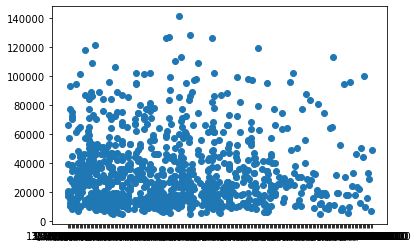

In [5]:
fig, ax = plt.subplots()

ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

We see from above that the `saledate` column is of `object` `dtype`, and therefore the plotter takes each entry as a discreet value and marks it on `x-axis`. This means that currently, for `saledate` there is no concept of series/sequence and each unique `saledate` entry has to be labeled on `x-axis`.

Therefore, lets plot something that uses numerical data on. Plotting histogram is a good choice. It divides the `SalePrice` in to bins (ranges) and shows the frequency for each bin.

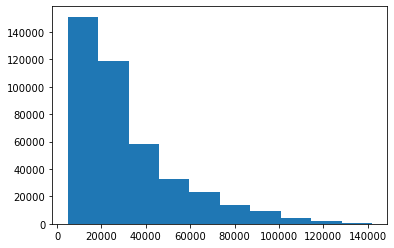

In [6]:
fig, ax = plt.subplots()

ax.hist(df["SalePrice"]);

## Parsing Dates
As shown earlier `saledate` column is an `object dtype`, and scatter plot without converting the column in to numeric is not of any use. Therefore, we need to tell the `pandas` that the `saledate` column contains dates.

When we work with time series data, we want to enrich the time and date component as much as possible. We can do that by telling pandas which of our columns has dates in it using the `parse_dates` paramter.

In [7]:
# Import data again, but this time parse the dates

df = pd.read_csv("../data/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])

In [8]:
df.head(10)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1139255,26500.0,1001274,4605,121,3.0,2004,508.0,Low,2008-12-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1139256,21000.0,772701,1937,121,3.0,1993,11540.0,High,2004-08-26,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
7,1139261,27000.0,902002,3539,121,3.0,2001,4883.0,High,2005-11-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1139272,21500.0,1036251,36003,121,3.0,2008,302.0,Low,2009-08-27,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
9,1139275,65000.0,1016474,3883,121,3.0,1000,20700.0,Medium,2007-08-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


In [9]:
df.saledate.dtype

dtype('<M8[ns]')

In [10]:
df.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

Now, we can plot the scatter plot between `SalePrice` and `saledate` and we can see that this time, the plot is more readable. Also notice that the scatter point positions are different than the previous plot.

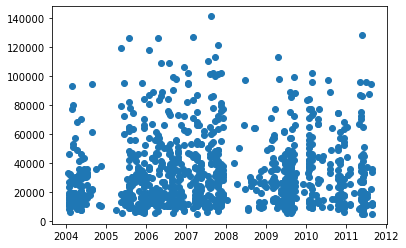

In [11]:
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000]);

In [12]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort Dataframe by saledate

When working with time series data, it's a good idea to sort it by date

In [14]:
# Sort dataframe in date order

df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make copy of the original DataFrame

We make a copy of the original dataframe so when we manupilate the copy, we've still got out original data

In [15]:
# Make a copy
df_tmp = df.copy()

### Add datetime parameters for `saledate` column

Now lets create new columns corresponding to year, month, day of month, day of week, day of year.

In [16]:
df_tmp["saledate"]

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
            ...    
410879   2012-04-28
412476   2012-04-28
411927   2012-04-28
407124   2012-04-28
409203   2012-04-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

In [17]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


Now that we have parsed the date and created separate column for each of the dates component, we can delete the `saledate` column

In [18]:
df_tmp.drop("saledate", axis=1, inplace=True)

A good way to see the structure of dataframe with many features is to use `df.head().T`. What htis does is first calls all columns and first 5 rows, then whole thing is transposed. This helps us see the data up close

In [19]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


Lets view the newly created `saleYear` column

In [20]:
df_tmp.saleYear

205615    1989
274835    1989
141296    1989
212552    1989
62755     1989
          ... 
410879    2012
412476    2012
411927    2012
407124    2012
409203    2012
Name: saleYear, Length: 412698, dtype: int64

The frequency of states inside the dataframe can be viewed as follows

In [21]:
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

# Modelling

When sufficient EDA has been done, then model driven EDA has to be performed. This means that we have to fit the model and then perform further EDA based on model performance

<hr>
<strong><p><font color="blue" face="consolas">In</font></p></strong>

``` Python
# Let's build a machine learning model

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, 
                              random_state=42)

model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

```

<hr>
<strong><p><font color="blue" face="consolas">Out</font></p></strong>

```python
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-37-32c0b9b673ab> in <module>
      6                               random_state=42)
      7 
----> 8 model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

~\machine-learning\milestone-project-2\env\lib\site-packages\sklearn\ensemble\_forest.py in fit(self, X, y, sample_weight)
    301                 "sparse multilabel-indicator for y is not supported."
    302             )
--> 303         X, y = self._validate_data(X, y, multi_output=True,
    304                                    accept_sparse="csc", dtype=DTYPE)
    305         if sample_weight is not None:

~\machine-learning\milestone-project-2\env\lib\site-packages\sklearn\base.py in _validate_data(self, X, y, reset, validate_separately, **check_params)
    430                 y = check_array(y, **check_y_params)
    431             else:
--> 432                 X, y = check_X_y(X, y, **check_params)
    433             out = X, y
    434 

~\machine-learning\milestone-project-2\env\lib\site-packages\sklearn\utils\validation.py in inner_f(*args, **kwargs)
     71                           FutureWarning)
     72         kwargs.update({k: arg for k, arg in zip(sig.parameters, args)})
---> 73         return f(**kwargs)
     74     return inner_f
     75 

~\machine-learning\milestone-project-2\env\lib\site-packages\sklearn\utils\validation.py in check_X_y(X, y, accept_sparse, accept_large_sparse, dtype, order, copy, force_all_finite, ensure_2d, allow_nd, multi_output, ensure_min_samples, ensure_min_features, y_numeric, estimator)
    794         raise ValueError("y cannot be None")
    795 
--> 796     X = check_array(X, accept_sparse=accept_sparse,
    797                     accept_large_sparse=accept_large_sparse,
    798                     dtype=dtype, order=order, copy=copy,

~\machine-learning\milestone-project-2\env\lib\site-packages\sklearn\utils\validation.py in inner_f(*args, **kwargs)
     71                           FutureWarning)
     72         kwargs.update({k: arg for k, arg in zip(sig.parameters, args)})
---> 73         return f(**kwargs)
     74     return inner_f
     75 

~\machine-learning\milestone-project-2\env\lib\site-packages\sklearn\utils\validation.py in check_array(array, accept_sparse, accept_large_sparse, dtype, order, copy, force_all_finite, ensure_2d, allow_nd, ensure_min_samples, ensure_min_features, estimator)
    597                     array = array.astype(dtype, casting="unsafe", copy=False)
    598                 else:
--> 599                     array = np.asarray(array, order=order, dtype=dtype)
    600             except ComplexWarning:
    601                 raise ValueError("Complex data not supported\n"

~\machine-learning\milestone-project-2\env\lib\site-packages\numpy\core\_asarray.py in asarray(a, dtype, order)
     83 
     84     """
---> 85     return array(a, dtype, copy=False, order=order)..."""
     86 
     87 

ValueError: could not convert string to float: 'Low'
```
<hr>

But we can fit the model yet since many of our columns are not in numeric value. Recall that `scikit-learn` models require that data be numerical. Moreover, we also haven't check for `null` or `NaN` entries in our data, and they also need to be dealt with before fitting data

In [22]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [23]:
df_tmp.UsageBand.dtype

dtype('O')

In [24]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## [Convert Strings to Categories](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.api.types.pandas_dtype.html#pandas.api.types.pandas_dtype)

Different datatype supported by pandas - Documentation Reference: [General Utility Functions](https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html)

In [25]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


We can use `pd.api.type.is_string_dtype(data)` to confirm whether `data` is of string type or not.

In [26]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

Since the pandas dataframe is basically a dictionary, `dict.items()` method can be called on pandas dataframe. And from out knowledge of dictionary, we know that `dict.items()` returns pair of key and values of the dictionary. Similarly, `df.items()` will return pair of `labels` and `content`. We can use this funtionality to loop the the dataframe and check which of the column has string datatype.

In [27]:
# Find the Columns containing strings

counter = 0
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)
        counter += 1
print(f"Number of columns with string data: {counter}")

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls
Number of columns with string data: 44


### Save preprocessed data

Before proceeding any further, we shoud save the preprocessed data, so the next time we open our notebook, instead of running all the cells, we can just pick it up from here.

In [28]:
# Export current tmp dataframe
df_tmp.to_csv('../data/train_tmp.csv', index=False)

In [29]:
# Import preprocessed data
df_tmp = pd.read_csv('../data/train_tmp.csv', low_memory=False)

<hr>

### `pandas` category functionality explained

[Official Documentation Reference](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html)


Categoricals are a pandas data type corresponding to categorical variables in statistics. A categorical variable takes on a limited, and usually fixed, number of possible values (categories; levels in R). Examples are gender, social class, blood type, country affiliation, observation time or rating via Likert scales.

In contrast to statistical categorical variables, categorical data might have an order (e.g. ‘strongly agree’ vs ‘agree’ or ‘first observation’ vs. ‘second observation’), but numerical operations (additions, divisions, …) are not possible.

All values of categorical data are either in `categories` or `np.nan` (in case category is not listed for the entry). Order is defined by the order of categories, not lexical order of the values. However by default, the order of categories is lexical, unless specified otherwise. Internally, the data structure consists of a *categories array* and an integer array of codes which point to the real value in the categories array. If *categories array* is defined by the user explicitly, then the order in which categories are listed will be the order of the categories.

When creating a series, we can define it to be category by including the argument `dtype='category'`. Alternatively we can convert an existing series or dataframe column to a categorical datatype by following codes:

<strong><p><font color="blue" face="consolas">In</font></p></strong>

```Python
# pd.Series defined with categorical declaration
s = pd.Series(['a', 'b', 'c', 'd'], dtype='category')
# pd.Series converted to categorical
s = pd.Sereis(['a', 'b', 'c', 'd'])
s = s.astype('category')

# similarly, DataFrame Column converted to categorical (assuming DataFrame is already defined as df)
df[column_name] = df[column_name].astype('category') 

```

To have more degree of control how category is created and intepreted, we can use `CategoricalDtype`. With this we can define the categories (as a separate data type) and define the whether they are ordered or not. And then we can convert data to newly created data type. See below...

<hr>
<strong><p><font color="blue" face="consolas">In</font></p></strong>

```python
from pandas.api.types import CategoricalDtype

s = pd.Series(["a", "b", "c", "a"])
cat_type = CategoricalDtype(categories=["b", "c", "d"], 
                            ordered=True)
s_cat = s.astype(cat_type)

s_cat

```

<hr>
<strong><p><font color="blue" face="consolas">Out</font></p></strong>

```
0    NaN
1      b
2      c
3    NaN
dtype: category
Categories (3, object): ['b' < 'c' < 'd']
```

<hr>

In the above example, since we explicity defined *categories array* `["b", "c", "d"]`, when `pandas` encountered data that is not in the already defined *categories array* (e.g. `'a'` is not defined), it converts it to `NaN`.

The argument `ordered=True` ensures that the order in which categories are defined is important. This can be verified in the last line of the output where category order is displayed as: `['b' < 'c' < 'd']`.


If the *categories array* is not defined explicitly, then the lexical order of entries would be considered the order of categories

<hr>
<strong><p><font color="blue" face="consolas">In</font></p></strong>

```python

from pandas.api.types import CategoricalDtype

s = pd.Series(["a", "b", "c", "a"])
cat_type = CategoricalDtype(ordered=True)
s_cat = s.astype(cat_type)

s_cat

```

<hr>
<strong><p><font color="blue" face="consolas">Out</font></p></strong>

```
0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): [a < b < c]

```
<hr>


Alternatively,

<hr>
<strong><p><font color="blue" face="consolas">In</font></p></strong>

```python

s = pd.Series(["a", "b", "c", "a"])
s_cat = s.astype('category').cat.as_ordered()

s_cat

```

<hr>
<strong><p><font color="blue" face="consolas">Out</font></p></strong>

```
0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): [a < b < c]

```

<hr>


If pandas series or the DataFrame column is already categorical, but we would like to modify the categories, we can use `s.cat.set_categories()` or `df[label].cat.set_categories()` function to explicitly define the categories and choose whether the categories are ordered or not.

<hr>
<strong><p><font color="blue" face="consolas">In</font></p></strong>

```python
s = pd.Series([1, 2, 3, 1], dtype="category")
s = s.cat.set_categories([5, 8, 2, 3, 1], ordered=True)
s
```

<hr>
<strong><p><font color="blue" face="consolas">Out</font></p></strong>

```
0    1
1    2
2    3
3    1
dtype: category
Categories (5, int64): [5 < 8 < 2 < 3 < 1]
```

<hr>
<strong><p><font color="blue" face="consolas">In</font></p></strong>

```python
s = pd.Series([1, 2, 3, 1], dtype="category")
s = s.cat.set_categories([5, 8, 2, 3, 1], ordered=False)
s
```

<hr>
<strong><p><font color="blue" face="consolas">Out</font></p></strong>

```
0    1
1    2
2    3
3    1
dtype: category
Categories (5, int64): [5, 8, 2, 3, 1]
```

<hr>

Now, back to our project...

### Categorizing String Columns

Using the knowledge discussed above, we can initiate a for loop to find string datatype columns and turn them into ordered categories without explicitly defining categories (this will make the order of categories lexical)

In [30]:
# This will turn all string values in to category
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [31]:
df_tmp['state']

0              Texas
1            Florida
2            Florida
3            Florida
4            Florida
             ...    
412693    California
412694    California
412695    California
412696    California
412697    California
Name: state, Length: 412698, dtype: category
Categories (53, object): ['Alabama' < 'Alaska' < 'Arizona' < 'Arkansas' ... 'Washington DC' < 'West Virginia' < 'Wisconsin' < 'Wyoming']

The last line of the output shows that in `state` column, there are 53 categories and the order of those categories is alphabetical.

In [32]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [33]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

Previously, it was mentioned that

> Internally, the data structure consists of a ***categories array*** and an **integer array of codes*** which point to the real value in the categories array

We can access the codes of the categories by `df.label.cat.codes`. To see the mapping of categories to codes, we can create a dictionary and then convert it to dataframe. The generalized code is as below:

```python
code_dict = dict(zip(df.label.cat.codes, df_tmp.label))
code_df = pd.DataFrame(code_dict, index=[0]).T.reset_index()
code_df.columns = ['Code', 'State']
code_df
```

In [34]:
code_dict = dict(zip(df_tmp.state.cat.codes, df_tmp.state))
code_df = pd.DataFrame(code_dict, index=[0]).T.reset_index()
code_df.columns = ['Code', 'State']
code_df.index.name = 'Index'
code_df.head()


,Code,State
Index,,
0,43,Texas
1,8,Florida
2,9,Georgia
3,40,South Carolina
4,35,Oklahoma


If we sort the DataFrame with respect to the `State` column, we will see that the order of code assigned to each category corresponds to the lexical (alphabetical) order of the states. This is because we have not explicitly defined *categories array*, and therefore, by default lexical order is assigned

In [35]:
code_df.sort_values(by=['State'])

,Code,State
Index,,
29,0,Alabama
40,1,Alaska
6,2,Arizona
43,3,Arkansas
11,4,California
10,5,Colorado
20,6,Connecticut
33,7,Delaware
1,8,Florida


We can also see how many times each coategory code occurs in the DataFrame as follows

In [36]:
df_tmp.state.cat.codes.value_counts()

8     67320
43    53110
4     29761
48    16222
9     14633
19    13322
23    13240
34    12369
12    11540
5     11529
29    11156
32    10636
42    10298
0     10292
37    10234
40     9951
2      9364
31     8639
6      8276
22     7885
24     7178
27     6932
17     6627
16     5351
18     5096
13     4124
3      3933
30     3631
45     3046
44     2801
51     2745
28     2738
47     2353
11     2025
36     1911
21     1831
52     1672
14     1336
25     1336
35     1326
26      866
50      840
15      667
7       510
33      480
1       430
20      347
46      300
41      244
10      118
39       83
38       42
49        2
dtype: int64

Thanks to pandas categories, we now have a way to access all of our data in form of numbers. But we still have number of missing data. Let's check the ratio of missing data for each feature in our DataFrame

In [37]:
# Check the missing data
df_tmp.isna().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [38]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


## Fill Missing Values

### Fill Numeric Missing Values First

Lets print out the columns that have numerical data

In [39]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


To check which numeric column has null values we can use `pd.isnull()` function.

In [40]:
# Check which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


Alternatively,

<p><font color="blue" face="consolas">In</font></p>

```python
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if content.isna().sum() > 0:
            print(label)
```

<p><font color="blue" face="consolas">Out</font></p>

```
auctioneerID
MachineHoursCurrentMeter
```

In [41]:
# Fill numeric rows with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column to indicate whether the value was missing or not
            df_tmp[label+'_is_missing'] = pd.isnull(content)
            # Fill missing value with median
            df_tmp[label] = content.fillna(content.median())

Check again fu=or numeric null values...

In [42]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Check and see how many null values were filled...

In [43]:
# check how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [44]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Fill Categorical Values and Turning them into Numbers
Since we have dealth with numerical columns, lets filter them out so we can focus on the remaining columns.

In [45]:
# Check for columns which are not numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [46]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 59 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   SalesID                              412698 non-null  int64   
 1   SalePrice                            412698 non-null  float64 
 2   MachineID                            412698 non-null  int64   
 3   ModelID                              412698 non-null  int64   
 4   datasource                           412698 non-null  int64   
 5   auctioneerID                         412698 non-null  float64 
 6   YearMade                             412698 non-null  int64   
 7   MachineHoursCurrentMeter             412698 non-null  float64 
 8   UsageBand                            73670 non-null   category
 9   fiModelDesc                          412698 non-null  category
 10  fiBaseModel                          412698 non-null  category
 11  

The function `df.cat.codes` on a categorical data will list down the codes opposite the index value. To produce an array of codes we need to use `pd.Categorical(data).codes`

In [47]:
pd.Categorical(df_tmp['state']).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

We can use previous strategy to loop through the DataFrame and create columns to indicate missing values, and then we can set these categories to be equal to their code. Pandas Category assigns all missing value the code of `-1` (see below) and therefore we need to add `1` to each numeric assignment of the category.

We can verify the assignment of `-1` using the `UsageBand` column has about 82% missing values.

In [48]:
pd.Categorical(df_tmp.UsageBand).codes

array([-1, -1, -1, ..., -1, -1, -1], dtype=int8)

In [49]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate missing value
        df_tmp[label+'_is_missing'] = pd.isnull(content)
        
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes + 1

Let see the `UsageBand` column again...

In [50]:
pd.Categorical(df_tmp.UsageBand).codes

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

Value of zero indicate that the entry was missing

In [51]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [52]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [53]:
df_tmp.isna().sum()[:20]

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
dtype: int64

Now that all of the data is numeric and there are no missing value, we should be able to buil ML model

In [54]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [55]:
len(df_tmp)

412698

Our data is quite large, about 0.412 Million +. Therefore it is good practice to use a sub-sample of the data so that during intial stages when we are just getting the feel of the behaviour of model with the data, not too much time is consumed.

Lets use Jupyter magic function to see how much time can single training take on the complete training data.

In [56]:
from sklearn.ensemble import RandomForestRegressor

<p><font color="blue" face="consolas">In</font></p>

```python
%%time
# Instantiate the model
model = RandomForestRegressor(n_jobs=-1, 
                              random_state=42)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1)[:20000], df_tmp["SalePrice"][:20000])
```

<p><font color="blue" face="consolas">Out</font></p>

```
Wall time: 8min 48s

RandomForestRegressor(n_jobs=-1, random_state=42)
```

As we all know, ML is highly empirical and highly iterative process, therefore before getting our final model we are very likely to experiment a lot and try different hyperparameter values. Therefore, 8 minutes for each experiment is certainly a lot and we will need address this issue going forward.

But for now lets use the first 20,000 examples, so that reloading the notebook is easier.

In [57]:
%%time
# Instantiate the model
model = RandomForestRegressor(n_jobs=-1, 
                              random_state=42)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1)[:20000], df_tmp["SalePrice"][:20000])

Wall time: 12.4 s


RandomForestRegressor(n_jobs=-1, random_state=42)

Let us now evalute the score of out model

In [58]:
model.score(df_tmp.drop("SalePrice", axis=1)[:20000], df_tmp["SalePrice"][:20000])

0.9863036934498179

The score above is not very reliable since we trained the model on both train and validation set and then evaluated performance on the data we used to train. In practice, we should train the model using training set and then use validation set to tune hyperparameters. Once best performing hyperparamters are selected, then we use test set to evaluate the model. If the model does not perform well on test set, we need to take another approach to the problem because we are no longer allowed to change hyperparamter based on the performance of model on the test set. Therefore, correct way would be to split the `TrainAndValid.csv` into Train and Valid datasets then fit the model on it.

> <p><font color='Red' face='Times New Roman' size=4><em><u>Attention!!</u></em></font></p>
> <p><font color='Red' face='Times New Roman'><em>We have filled the missing numerical values using the complete</em> <font color='blue' face='consolas'>TrainAndValid.csv</font> <em>and this means that the validation set influences the values used for filling numerical values. This is not good practice since this leads to model learning some features of the validation set during training. Therefore, it is imperative that once the dates are parsed and enriched and the categorical columns have been encoded, the dataset must be sliced immediately. Afterwards we can perform data filling on training set and use the same values to fill the validation set</em></font></p>



## Filling Values using the Correct Method

Lets import the `train_tmp.csv` we saved after parsing time and do everything after that from the scratch the right way.

In [59]:
df_tmp = pd.read_csv('../data/train_tmp.csv', low_memory=False)

Lets take a look at the data and see if everything is in order

In [60]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


The last rows in the above transposed table shows that as expected, the `saleDate` column has been parsed and converted different columns with integer values.

We will now use `df.info()` to see data structure of the dataset

In [61]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

We can see that there are many columns with object type. To confirm if they are string we will use `pd.api.types.is_string_dtype()`

In [62]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


All of the above columns have strain datatype. We can convert these columns into categoricals.

In [63]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = df_tmp[label].astype('category').cat.as_ordered()   

In [64]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

Now that we have make these columns categorical, now we will convert them into numerical value using category codes

In [65]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_tmp[label+'_is_missing'] = pd.isnull(content)
        df_tmp[label] = pd.Categorical(content).codes + 1

In [66]:
pd.Categorical(df_tmp.UsageBand)

[0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0]
Length: 412698
Categories (4, int64): [0, 1, 2, 3]

_Now lets split the dataset._

From the data description in Kaggle, we know that the whole `TrainAndValid.csv` dataset is till Apr 30, 2012 and the train dataset is till the end of 2011. Hence the validation dataset will be every entry in the year 2012. We can use this information to split the dataset

In [67]:
# Split the into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012].copy()
df_train = df_tmp[df_tmp.saleYear != 2012].copy()

In the above code, explicit copy is made, because otherwise, the Dataframes `df_val` and `df_train` would have just referenced to `df_tmp` with relevant indices

Lets see the length of each split and evaluate the split ratio

In [68]:
len(df_val), len(df_train), len(df_train)/(len(df_train)+len(df_val))

(11573, 401125, 0.9719577027269335)

Now, lets split separate the X and y from each set

## Filling Missing Value
This step involves filling missing numerical values and converting the categoricals columns to numeric columns. Keep in mind we have already converted categorical to numeric since no statistical data was used in the process, and therefore, there was no data leakage from validation set to training set.

### Filling Missing Numerical Values

In [69]:
print("Missing values in Training Dataset:")
print("--------------------------------------")
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Missing values in Training Dataset:
--------------------------------------
auctioneerID
MachineHoursCurrentMeter


We will these missing numerical values with median of the column. In validation set, we will use the corresponding median value of the training set

>*In statistics and probability theory, a median is a value separating the higher half from the lower half of a data sample, a population or a probability distribution. For a data set, it may be thought of as "the middle" value*. In other words, median is the middle value of a sorted list.

The reason why median is preferred is because, it avoids outliers from influencing the process of filling in the missing values. All other statistical quatities are one way or another influenced by outliers except median.

In [70]:
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_train[label + '_is_missing'] = pd.isnull(content)
            df_val[label + '_is_missing'] = False
            df_train[label] = content.fillna(content.median())
            

In the above code, while adding columns with `_is_missing` label for columns with `NaN` in training dataset, we will also add the same column to the `df_val` and set all the values to `False` in the new columns of `df_val`. This is done because it is possible that the `df_val` may not contain `NaN` in all the columns that `df_train` does

Checking to see if there is any remaining `NaN` values remaining

In [71]:
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
            
print("End of list")

End of list


In [72]:
df_train.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,False,False,False,True,True,False,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,False,False,False,True
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,False,False,False,True,True,False,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,False,False,False,True
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,False,False,False,True,True,False,True


Now filling the validation set with median of training set

In [73]:
print("Missing values in Training Dataset:")
print("--------------------------------------")
for label, content in df_val.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Missing values in Training Dataset:
--------------------------------------
MachineHoursCurrentMeter


In [74]:
for label, content in df_val.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_val[label + '_is_missing'] = pd.isnull(content)
            df_val[label] = content.fillna(df_train[label].median())

In [75]:
for label, content in df_val.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
            
print("End of list")

End of list


In [76]:
df_val.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
401125,4449186,46173.2,2318824,26964,173,99.0,1996,0.0,0,2269,...,True,True,True,False,False,False,True,True,False,False
401126,1222855,66000.0,531393,23926,121,3.0,1000,8145.0,2,85,...,True,True,True,True,True,True,True,True,False,False
401127,6258613,26800.0,1810917,13260,149,99.0,2000,24.0,2,1115,...,True,True,True,True,True,True,True,True,False,False
401128,6282680,42100.0,1543404,1830,149,99.0,2004,4373.0,3,64,...,False,False,False,True,True,True,True,True,False,False
401129,6282759,62100.0,1863077,11390,149,99.0,2006,3467.0,3,139,...,False,False,False,True,True,True,True,True,False,False


### Splitting `X` and `y`

In [77]:
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_val, y_val = df_val.drop('SalePrice', axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((401125, 102), (401125,), (11573, 102), (11573,))

Again, since the dataset is too large, the training and scoring of complete set are shown in form of static code and it output:

<p><font color="blue" face="consolas">[In]</font></p>

```python
from sklearn.ensemble import RandomForestRegressor
%%time
# Instantiate the model
model = RandomForestRegressor(n_jobs=-1, random_state=42)

# Train the model
model.fit(X_train, y_train)
```

<p><font color="blue" face="consolas">[Out]</font></p>

```
Wall time: 8min 40s

RandomForestRegressor(n_jobs=-1, random_state=42)
```

<p><font color="blue" face="consolas">[In]</font></p>

```python
train_score = model.score(X_train, y_train)
print(f"Model score on Training Set: {train_score}")

val_score = model.score(X_val, y_val)
print(f"Model score on Validation Set: {val_score}")

```

<p><font color="blue" face="consolas">[Out]</font></p>

```
Model score on Training Set: 0.9875102380428772
Model score on Validation Set: 0.8724375918864498
```

### Creating an Evaluation Function
The default evaluation metric for regression problems in `sklearn` is the RMSE, but the project requirement is to evaluate the model on RMSLE (Root Mean Squared Log Error). So we will create a custom function to evaluate the model on different criteria including RMSLE and display the output in DataFrame

In [78]:
# Create Evaluating Function

def rmsle(y_truth, y_preds):
    """
    Calculates root mean sqaured log error between predictions and true labels
    """
    from sklearn.metrics import mean_squared_log_error

    return np.sqrt(mean_squared_log_error(y_truth, y_preds))

# Create a function to evaluate the model on few different levels
def show_scores(model):
    from sklearn.metrics import mean_absolute_error, r2_score
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    
    scores = {"Training":{"MAE": mean_absolute_error(y_train, train_preds),
                         "RMSLE": rmsle( y_train, train_preds),
                         "R2": r2_score(y_train, train_preds)
                        },
            "Validation":{"MAE":mean_absolute_error(y_val, val_preds),
                          "RMSLE":rmsle(y_val, val_preds),
                          "R2":r2_score(y_val, val_preds)
                         }
            }
    scores_df = pd.DataFrame(scores)
    return scores_df



## Testing Model on a Subset (To Tune Hyperparameters)

We can set the `max_samples` hyperparameter of the model to a lower value to reduce computational cost during hyperparameter tuning.The `max_sample` hyperparameter determines how much data to pick from `X_train` for each estimator in the model. The default value of `max_samples` is the length of the training set. By default, number of estimators in each model are 100, i.e.`n_estimator=100`.

The official description of RandomForest mentioning `n_estimators` and `max_samples` is:

>*A random forest is a meta estimator that fits a number of decision tree regressors (`n_estimators`) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the `max_samples` parameter if `bootstrap=True` (default), otherwise the whole dataset is used to build each tree.*


In [79]:
len(X_train), len(X_val)

(401125, 11573)

In [80]:
# Change max samples value for Random Forest Regressor
model = RandomForestRegressor(n_jobs=-1, 
                              random_state=42, 
                              max_samples=10000)

In [81]:
%%time
# Cutting down on max_samples, each estimator should take less time
model.fit(X_train, y_train)

Wall time: 20.4 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [82]:
show_scores(model)

,Training,Validation
MAE,5562.095337,7170.174067
RMSLE,0.257699,0.292674
R2,0.860554,0.832340


### Hyperparameter Tuning Randomized Search CV

In [84]:
# %%time
from sklearn.model_selection import RandomizedSearchCV

# Create a hyperparameter grid
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]
          }
# Instantiate the RandomizedSearchCV class
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), 
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   57.9s finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

Best params with `n_iter=100`:

```
{'n_estimators': 40,
 'min_samples_split': 2,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}
```
Best params with `n_iter=2`:

In [85]:
best_params = rs_model.best_params_
best_params

{'n_estimators': 40,
 'min_samples_split': 12,
 'min_samples_leaf': 9,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': None}

In [ ]:
show_scores(rs_model)

The most ideal model from tutorial is:
```python
ideal_model_mrdbourke = RandomForestRegressor(n_estimators=40,
                                              min_samples_leaf=1,
                                              min_samples_split=14,
                                              max_features=0.5,
                                              max_depth=10
                                              n_jobs=-1,
                                              random_state=42)
ideal_model_mrdbourke.fit(X_train, y_train)
```

In [93]:
# Instantiation of the ideal model with best hyperparameters found
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_split=2,
                                    min_samples_leaf=7,
                                    max_features='auto',
                                    max_depth=None,
                                    n_jobs=-1, 
                                    random_state=42)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=7, n_estimators=40, n_jobs=-1,
                      random_state=42)

In [94]:
show_scores(ideal_model)

,Training,Validation
MAE,3358.259994,6114.101243
RMSLE,0.164867,0.251402
R2,0.943644,0.870287
